# load import libraries

In [1]:
#Aim is 1-D receiver function analysis
import numpy as np
import math
import obspy
from seispy.decon import RFTrace
import seispy
import scipy
import scipy.io as sio
import scipy.io as spio
import scipy.io
from scipy.io import savemat
from scipy.io import loadmat
from matplotlib import pyplot as plt
from future.utils import native_str
import os
from obspy.core import UTCDateTime
import sys
from scipy import interpolate
from scipy.interpolate import interp1d
from os.path import dirname, join as pjoin
from scipy import signal
from obspy import read
import pandas as pd


# Set All Parameters

# Code, Function[dseis] = decon(fseis,source,water_level)
# RF function

In [2]:
def reciever_function(trace,source,water_level=1000,tshift=10):
    '''
    reciever_function(trace,source,water_level=1000,tshift=10),input the seismic Trace(E,N,Z) direction 
    and rotate it in (R-T-Z)component,
    source and trace are the single traces, producing a single deconvolved trace. Where each trace in input 
    Trace is deconvohttps://github.com/PATH-TO/REPOSITORYlved by each corresponding Source 
    and apply ifft,(the value of water_level(damping factor) and tshift have been
    recommended).Having all to make
    Reciever_function for the station.
    '''
    slength = (trace.data).shape[0]
    source_matrix = np.matrix(source)
    nsrc = source_matrix.shape[0]
    trace_matrix = np.matrix(trace)
    ntr = trace_matrix.shape[0]
    n2=2**(math.ceil(math.log(slength)/math.log(2)))
    omega = np.arange(0,n2/2)*2*(math.pi)/(n2*delta)
    wtshift = -(1j)*omega*tshift
    traceft = np.fft.fft([st_rot.traces[1].data],n2,axis=1)
    sourceft = np.fft.fft([st_rot.traces[2].data],n2,axis=1)
    traceft = traceft[:,0:int(n2/2)]
    sourceft = sourceft[:,0:int(n2/2)]
    traceft_real = (traceft.real)[0]
    sourceft_real = (sourceft.real)[0]
    dseisft = np.multiply(traceft,np.conjugate(sourceft))/(np.multiply(sourceft,np.conjugate(sourceft))+water_level)
    dseisft_real = (dseisft.real)[0]
    zeros_wtshift = np.zeros_like(wtshift)
    dseisft=np.multiply(dseisft,(np.ones((1,1))*np.exp(zeros_wtshift)))
    dseisfttrans = np.array(np.transpose(dseisft))
    dseisftfinal =np.concatenate([dseisfttrans,np.fliplr(np.conjugate(dseisfttrans[1:int(n2/2)]))])
    rf = np.fft.irfft(dseisftfinal,n2,0)
    rf = (rf[0:slength])
    return(rf,omega,wtshift,dseisft_real) 

In [13]:
st = obspy.read('/home/zahra/reciever function/Poin/CN.POIN..HH*_2018-12-05T04_32_12.148_2018-12-05T04_43_12.148.sac')
print(st)
st.resample(20)
dt = UTCDateTime("2018-12-05T04:32:12")
st.trim(starttime = dt, endtime=dt+100.1)
print(st)
tr = st[0]
print(tr.stats)
delta =0.01
water_level=1000
da = seispy.distaz(st[0].stats.sac.stla, st[0].stats.sac.stlo,st[0].stats.sac.evla, st[0].stats.sac.evlo)
dis = da.delta
bazi = da.baz
ev_dep = st[0].stats.sac.evdp
print('Distance = %5.2f˚' %dis)
print('back_azimuth = %5.2f˚' %bazi)
st_rot = st.copy().rotate("NE->RT", back_azimuth=bazi)
trace =  st_rot.traces[1]
source = st_rot.traces[2]

rf,omega,wtshift,dseisft_real=reciever_function(trace,source,water_level)

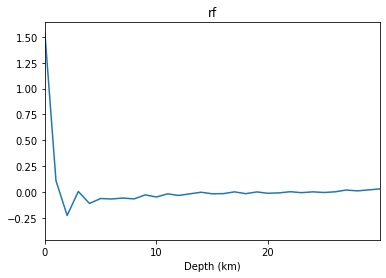

In [4]:
plt.title("rf")
plt.plot(rf)
plt.xlim(0, 30)
plt.xticks(np.arange(0, 30,10))
plt.xlabel('Depth (km)')
plt.show()

# Mapping to Depth the Receiver Function

In [5]:
dt= 0.05
tshift =10
rfun = rf
rfunt = np.transpose(rfun)
primarily_prfun= int(np.fix(tshift/dt)-1)
prfun = rfunt[0:primarily_prfun]
rfunt = rfunt[int(np.fix(tshift/dt)-1):]
rfunt.shape

(0, 2000)

In [11]:
def map_1rf_function(rf,rfun,prfun,tcut1,tcut2,tcut3,depth1,depth2,depth3,rayp=0.0712,tshift=10,dt = 0.05):
    
    
    '''
    Map of single receiver function RFUN with the ray_parameter(s/km)
    as RAYP to the depth by 1D migration.we are going to use velocity model(thress simple layer model) that 
    we have in MATLAB and import it here as a mat file.
    '''
    rfun = rf
    rayp=0.0712
    primarily_prfun= int(np.fix(tshift/dt)-1)
    prfun = rfun[0:primarily_prfun]
    prfunt=np.transpose(prfun)
    rfun = rfun[int(np.fix(tshift/dt)-1):]

    data_dir = pjoin(dirname(sio.__file__), 'matlab', 'tests', 'data')
    mat_fname = pjoin(data_dir, '/home/zahra/reciever function/poin1/vmod.mat')
    mat_contents = sio.loadmat(mat_fname)
    sorted(mat_contents.keys())
    matstruct_fname = pjoin(data_dir,'/home/zahra/reciever function/poin1/vmod.mat')
    matstruct_contents = sio.loadmat(matstruct_fname)
    teststructt = matstruct_contents['vmod']
    vmod=teststructt
    d1=vmod[:,0]
    d2=vmod[:,1]+0.001
    vp=vmod[:,2]
    vs=vmod[:,3]
    rho=vmod[:,4]    
    tcut1=np.zeros(len(d2)+1)
    tcut2=np.zeros(len(d2)+1)
    tcut3=np.zeros(len(d2)+1)
    tcut1[0] = 0
    tcut2[0] = 0
    tcut3[0] = 0
    depth1 = np.zeros(len(rfun))
    depth2 = np.zeros(len(rfun))
    depth3 = np.zeros(len(rfun))
    for i in (range(1,(len(d2)+1))): 
        tcut1[i]= (np.sqrt(1/vs[i-1]**2-rayp**2) - np.sqrt(1/vp[i-1]**2 - rayp**2)) * (d2[i-1]-d1[i-1])+tcut1[i-1]
        tcut2[i]=(np.sqrt (1/vs[i-1]**2-rayp**2)+ np.sqrt (1/vp[i-1]**2-rayp**2))* (d2[i-1]-d1[i-1])+tcut2[i-1]
        tcut3[i]=(2*np.sqrt ((1/vs[i-1])**2-rayp**2))*(d2[i-1]-d1[i-1])+tcut3[i-1]
    for i in range(0,(len(rfun))):
        rftime = (i+1)*dt
        tt1 = np.asarray(np.nonzero(tcut1<rftime))
        tt2 = np.asarray(np.nonzero(tcut2<rftime))
        tt3 = np.asarray(np.nonzero(tcut3<rftime))
        depth1[i] = d1[np.max([tt1])]+(rftime-tcut1[np.max([tt1])])/(np.sqrt((1/vs[np.max([tt1])])**2-rayp**2)-np.sqrt((1/vp[np.max([tt1])])**2-rayp**2))
        depth2[i] = d1[np.max([tt2])]+(rftime-tcut2[np.max([tt2])])/(np.sqrt((1/vs[np.max([tt2])])**2-rayp**2)+np.sqrt((1/vp[np.max([tt2])])**2-rayp**2))
        depth3[i] = d1[np.max([tt3])]+(rftime-tcut3[np.max([tt3])])/(2*np.sqrt((1/vs[np.max([tt3])])**2-rayp**2))
    dd = np.arange(start=-5, stop=100.1, step=0.1)
    idx1 = np.asarray(np.nonzero(depth1<=110))
    idxp1 = np.asarray(np.nonzero(depth1<=10))
    idx2 = np.asarray(np.nonzero(depth2<=110))
    idxp2 = np.asarray(np.nonzero(depth2<=10))
    idx3 = np.asarray(np.nonzero(depth3<=110))
    idxp3 = np.asarray(np.nonzero(depth3<=10))
    part1_x1=(-(np.fliplr(depth1[idxp1])))
    part2_x1 = np.append(part1_x1,0)
    part3 = np.array(depth1[idx1[0:len(idx1)]])
    part3_x1 =  part3[0,:len(part3)-2]
    x1 = np.append(part2_x1,part3_x1)
    v1_part1 = np.fliplr(prfun[len(prfun)-2-idxp1])
    v1_part2 = (rfun[(idx1)])
    v1 = np.append(v1_part1,v1_part2)
    rfun1 = np.interp(dd,x1,v1)
    part1_x2 = (-(np.fliplr(depth2[idxp2])))
    part2_x2 = np.append(part1_x2,0)
    part3x2 =  np.asarray(depth2[idx2[0,]])
    part3_x2 = part3x2[:len(part3x2)-1]
    x2 = np.append(part2_x2 ,part3_x2)
    v2_part1 = np.fliplr(prfun[len(prfun)-2-idxp2])
    v2_part2 = np.transpose(rfun[(idx2)])
    v2 = np.append(v2_part1,v2_part2)
    rfun2 = np.interp(dd,x2,v2)
    part1_x3 = (-(np.fliplr(depth3[idxp3])))
    part2_x3 = np.append(part1_x3 ,0)
    part3x3 = np.asarray(depth3[idx3[0,]])
    part3_x3 = part3x3[:len(part3x3)-1]
    x3 = np.append(part2_x3,part3_x3)
    v3_part1 = np.fliplr(prfun[len(prfunt)-2-idxp3])
    v3_part2 = np.transpose(rfun[(idx3)])
    v3 = np.append(v3_part1,v3_part2)
    rfun3 = np.interp(dd,x3,v3)
    fig_object = plt.figure()
    plt.plot(dd,rfun1)
    plt.title('Forward (standard) receiver function')
    plt.xlabel('Depth (km)')
    lh = plt.legend(('Ps',))
    plt.legend('Ps')
    print('Press any key to display forward and reflected receiver functions')
    plt.show()
    wait = input("Press Enter to continue.")
    plt.savefig('total,dd.png')
    plt.xlabel('Forward and reflected (multiple-based) receiver function')
    plt.subplot(4,1,1)
    plt.plot(dd, rfun1)
    plt.legend(('Ps',),loc="upper right")
    plt.xlabel('Forward and reflected (multiple-based) receiver function')
    plt.subplot(4,1,2)
    idx2 = np.asarray(np.nonzero(depth2<=110))
    idxp2 = np.asarray(np.nonzero(depth2<=10))
    rfun2 = np.interp(dd,x2,v2)
    plt.plot(dd,rfun2)
    plt.legend(('Pps',),loc="upper right")
    plt.subplot(4,1,3)
    idx3 = np.asarray(np.nonzero(depth3<=110))
    idxp3 = np.asarray(np.nonzero(depth3<=10))
    plt.plot(dd,-rfun3)
    plt.legend(('Pss',),loc="upper right")
    plt.subplot(4,1,4)
    plt.plot(dd,rfun1+rfun2-rfun3)
    plt.legend(('sum of modes',),loc="upper right")
    plt.plot(label='Depth (km)')
    plt.tight_layout()

Press any key to display forward and reflected receiver functions


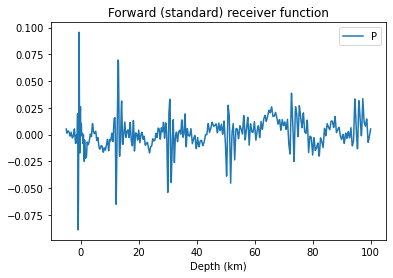

Press Enter to continue.


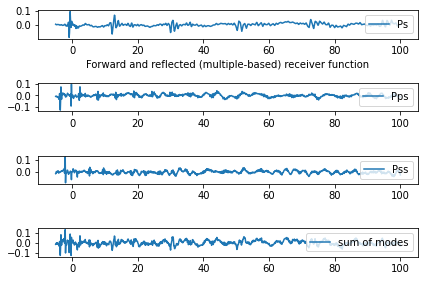

In [12]:
map_1rf_function(rf,rfun,prfun,tcut1,tcut2,tcut3,depth1,depth2,depth3,rayp=0.0712,tshift=10,dt =0.05)